# <div align='center'>第4章 回归分析</div>

## 4.3 逐步回归与模型选择
当回归模型的自变量过多时，需要压缩自变量，方法主要有两种：一是逐步回归； 二是模型选择的正则化方法，比如岭回归和Lasso。

 ### 4.3.1 逐步回归
 

- #### 示例：
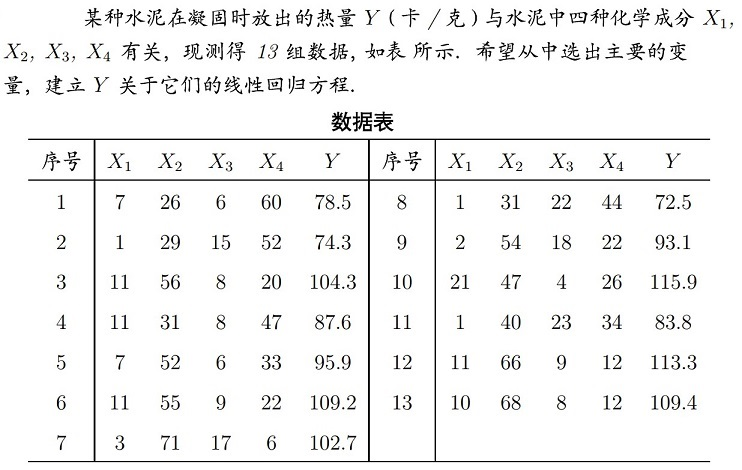

In [2]:
'''
使用调整后R方作为标准选择最佳模型，
也可以使用AIC,BIC,PRESS等统计量
'''
import statsmodels.formula.api as smf

'''
data: Pandas的DataFrame类型数据
response: 因变量(响应变量)
'''
def forward_selected(data, response):
    #remaining = set(data.columns)
    ###自变量名称，从DataFrame取出
    remaining=list(data.columns)
    ###从数据里去掉响应变量，作为自变量列表
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    print('-----------初始变量列表：',remaining)
    i=1
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        ###从剩余变量中弹出一个变量迭代加入模型
        for candidate in remaining:
            formula = "{} ~ 1 + {}".format(response, ' + '.join(selected + [candidate]))
            result = smf.ols(formula, data).fit()
            score = result.rsquared_adj
            aic = result.aic
            #press准则：Prediction Error of Square Sum
            #预测误差平方和
            press=np.sum(result.get_influence().resid_press**2)
            scores_with_candidates.append((score, candidate))
            print('\n模型：',formula,'\n调整后R方：',np.round(score,3),
                  ', AIC:',np.round(aic,3),'PRESS:',np.round(press,3))
        ###对模型按照score排序，list对象的sort函数是从小到大排序
        scores_with_candidates.sort()
        ###弹出一个变量及其评分，注意list的pop函数是弹出最后一个元素，即最大评分的自变量组合
        best_new_score, best_candidate = scores_with_candidates.pop()
        
        ###通过rsquared_adj比较模型自变量增减前后的模型效果。
        ###如果rsquared_adj增加，则从selected中移除候选模型，增加新的最佳模型。
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
        print('-----------remaining',i,'-',remaining)
        print('+++++++++++selected',i,'-',selected)
        i=i+1
    formula = "{} ~ 1+ {}".format(response,' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model,scores_with_candidates

In [3]:
import pandas as pd
import numpy as np
###导入数据
X1=np.array([7,  1, 11, 11,  7, 11,  3,  1,  2, 21,  1, 11, 10])
X2=np.array([26, 29, 56, 31, 52, 55, 71, 31, 54, 47, 40, 66, 68])
X3=np.array([6, 15,  8,  8,  6,  9, 17, 22, 18,  4, 23,  9,  8])
X4=np.array([60, 52, 20, 47, 33, 22,  6, 44, 22, 26, 34, 12, 12])
Y =np.array([78.5, 74.3, 104.3,  87.6,  95.9, 109.2, 102.7, 72.5,
            93.1,115.9,  83.8, 113.3, 109.4])
data=pd.DataFrame(np.array([X1,X2,X3,X4,Y]).T,columns=['X1','X2','X3','X4','Y'])
model,swc = forward_selected(data, 'Y')
model.summary()

-----------初始变量列表： ['X1', 'X2', 'X3', 'X4']

模型： Y ~ 1 + X1 
调整后R方： 0.492 , AIC: 100.412 PRESS: 1699.612

模型： Y ~ 1 + X2 
调整后R方： 0.636 , AIC: 96.07 PRESS: 1202.087

模型： Y ~ 1 + X3 
调整后R方： 0.221 , AIC: 105.96 PRESS: 2616.364

模型： Y ~ 1 + X4 
调整后R方： 0.645 , AIC: 95.744 PRESS: 1194.218
-----------remaining 1 - ['X1', 'X2', 'X3']
+++++++++++selected 1 - ['X4']

模型： Y ~ 1 + X4 + X1 
调整后R方： 0.967 , AIC: 65.634 PRESS: 121.224

模型： Y ~ 1 + X4 + X2 
调整后R方： 0.616 , AIC: 97.522 PRESS: 1461.814

模型： Y ~ 1 + X4 + X3 
调整后R方： 0.922 , AIC: 76.745 PRESS: 294.014
-----------remaining 2 - ['X2', 'X3']
+++++++++++selected 2 - ['X4', 'X1']

模型： Y ~ 1 + X4 + X1 + X2 
调整后R方： 0.976 , AIC: 61.866 PRESS: 85.351

模型： Y ~ 1 + X4 + X1 + X3 
调整后R方： 0.975 , AIC: 62.62 PRESS: 94.537
-----------remaining 3 - ['X3']
+++++++++++selected 3 - ['X4', 'X1', 'X2']

模型： Y ~ 1 + X4 + X1 + X2 + X3 
调整后R方： 0.974 , AIC: 63.837 PRESS: 110.347
-----------remaining 4 - ['X3']
+++++++++++selected 4 - ['X4', 'X1', 'X2']


f:\users\hp\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     166.8
Date:                Mon, 16 Aug 2021   Prob (F-statistic):           3.32e-08
Time:                        12:11:36   Log-Likelihood:                -26.933
No. Observations:                  13   AIC:                             61.87
Df Residuals:                       9   BIC:                             64.13
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     71.6483     14.142      5.066      0.001      39.656     103.641
X4            -0.2365      0.173     -1.365      0.205      -0.629       0.155
X1             1.4519      0.117     12.410      0.000       1.187       1.717
X2             0.4161      0.186      2.242      0.052      -0.004       0.836
==============================================================================
Omnibus:                        0.211   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.900   Jarque-Bera (JB):                0.378
Skew:                           0.202   Prob(JB):                        0.828
Kurtosis:                       2.270   Cond. No.                     1.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
'''
根据变量X4的t检验结果
'''
formula='Y~X1+X2'
result=smf.ols(formula,data=data).fit()
print(result.summary())

'''
PRESS(预测误差平方和)统计量
'''
press = np.round(np.sum(result.get_influence().resid_press**2),3)
print('\n模型Y~X1+X2的PRESS：',press)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     229.5
Date:                Mon, 16 Aug 2021   Prob (F-statistic):           4.41e-09
Time:                        12:11:38   Log-Likelihood:                -28.156
No. Observations:                  13   AIC:                             62.31
Df Residuals:                      10   BIC:                             64.01
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     52.5773      2.286     22.998      0.0

f:\users\hp\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


----------

### 4.3.2 模型压缩与正则化
主要包含岭回归（Ridge regression）和Lasso两种方法，二者的主要原理是将系数往等于0的方向压缩。



- #### 示例1：岭回归
使用信用卡数据进行岭回归。<br>
信用卡数据字段：<br>
Income：收入，Limit：信用额度，Rating：信用等级，Cards：信用卡数，	Age：年龄，	Education：教育程度 ，Gender：性别，Student：是否学生，Married：是否已婚，Ethnicity：种族，Balance：余额

In [5]:
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import patsy
data = pd.read_csv(r'e:\data\credit.csv',index_col=0)
print('数据形状：',data.shape)
print('\n数据示例：')
data.head(10)

数据形状： (400, 11)

数据示例：


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
6,80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151
7,20.996,3388,259,2,37,12,Female,No,No,African American,203
8,71.408,7114,512,2,87,9,Male,No,No,Asian,872
9,15.125,3300,266,5,66,13,Female,No,No,Caucasian,279
10,71.061,6819,491,3,41,19,Female,Yes,Yes,African American,1350


In [6]:
'''
使用Income,Limit,Rating,Student四个属性作为自变量，使用Balance做因变量
构建模型，即通过收入，信用额度，信用等级和是否学生来预测余额。
对于超参数lambda，设定从10^(-2)到10^10次方超参数集等距挑选100个数进行测试。
'''
X = data[['Income','Limit','Rating','Student']]
y = data['Balance']
###将因子变量映射成0,1
X['Student'] = X['Student'].map({'Yes':1,'No':0})
###对数字变量进行标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
formula = 'y~X'
model=smf.ols(formula,data={'y':y,'X':X_scaled})
result=model.fit()
result.summary()


f:\users\hp\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     1967.
Date:                Mon, 16 Aug 2021   Prob (F-statistic):          3.06e-259
Time:                        12:11:42   Log-Likelihood:                -2411.3
No. Observations:                 400   AIC:                             4833.
Df Residuals:                     395   BIC:                             4852.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    520.0150      5.052    102.934      0.000     510.083     529.947
X[0]        -279.6526      8.288    -33.742      0.000    -295.947    -263.359
X[1]         280.5161     64.231      4.367      0.000     154.239     406.793
X[2]         338.4898     64.121      5.279      0.000     212.430     464.550
X[3]         126.8005      5.062     25.049      0.000     116.848     136.753
==============================================================================
Omnibus:                       24.527   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.945
Skew:                           0.647   Prob(JB):                     8.55e-07
Kurtosis:                       2.963   Cond. No.                         29.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

f:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


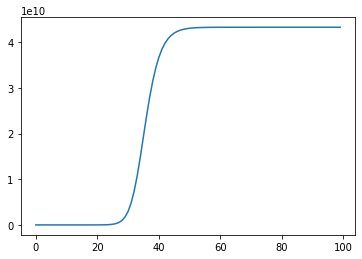

(4.326563071665612, 1e-05)

In [7]:
mse = []###残差均方
###超参数的范围，100个，从10^-2到10^10
lam=10**np.linspace(-5,10,100)
###Statsmodels有一个岭回归和Lasso的简单实现即fit_regularized函数
for l in lam:
    ###L1_wt:0为岭回归；1为Lasso；0-1之间为ElasticNet算法
    result = model.fit_regularized(L1_wt=0,alpha=l,refit=True,profile_scale=False)
    ###使用原始数据进行预测
    pred=result.predict()
    ###计算残差均方
    mse.append(np.sum(y-pred)**2)
    
sns.lineplot(np.arange(0,len(mse)),mse)
plt.show()
lammin=lam[np.argmin(mse)]
###最小均方残差以及lambda超参数的值
np.min(mse),lammin

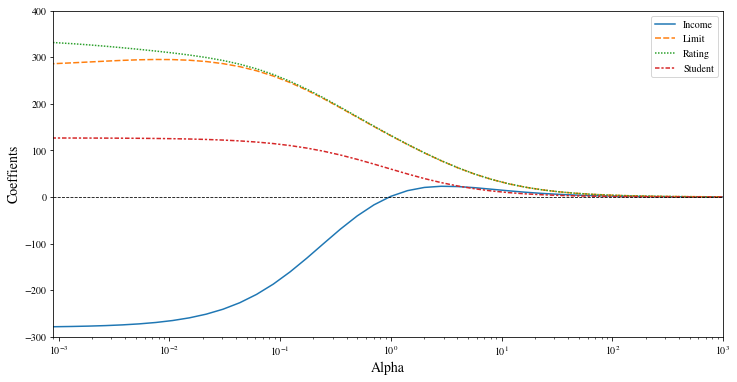

In [8]:
'''
岭回归随着lambda->Inf，压缩惩罚项影响力增加，岭回归系数估计值越接近0.
见下图。
'''
##超参数lambda，有的教材也用alpha

# 设置matplotlib参数，正确显示中文和'-'符号。
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
alpha=10**np.linspace(-5,10,100)
intercept_dict = {}
for a in alpha:
    result = model.fit_regularized(L1_wt=0,alpha=a,refit=True,profile_scale=True)
    ###保存每次迭代的回归系数估计值
    intercept_dict[a]=result.params
###lambda参数与对应的系数估计值，去掉截距项
params_l2 = pd.DataFrame(intercept_dict).T
params_l2=params_l2[[1,2,3,4]]
###行索引是alpha值，列索引是自变量名
params_l2.columns=['Income','Limit','Rating','Student']
plt.figure(figsize = (12,6))

###Seaborn使用行索引为X轴，每一列的数据为Y轴，绘制曲线
#列名作为示意图的标记。
sns.lineplot(data = params_l2,dashes=True)
plt.axhline(y = 0,linestyle = 'dashed',lw = 0.8,color = 'black')
plt.xticks(alpha)
###对X轴进行对数转换伸缩。
plt.xscale('log')
plt.ylim(-300,400)
plt.xlim(10**(-3)-0.0001,10**3)
plt.ylabel('Coeffients',size=14)
plt.xlabel('Alpha',size=14)
plt.show()

In [9]:
###不同lambda值下的回归系数，
params_l2

,Income,Limit,Rating,Student
1.000000e-05,-2.796386e+02,2.805992e+02,3.383925e+02,1.267993e+02
1.417474e-05,-2.796328e+02,2.806337e+02,3.383521e+02,1.267988e+02
2.009233e-05,-2.796245e+02,2.806825e+02,3.382949e+02,1.267980e+02
2.848036e-05,-2.796127e+02,2.807513e+02,3.382142e+02,1.267970e+02
4.037017e-05,-2.795961e+02,2.808481e+02,3.381004e+02,1.267955e+02
...,...,...,...,...
2.477076e+09,8.594953e-08,1.597357e-07,1.600930e-07,4.801494e-08
3.511192e+09,6.063569e-08,1.126904e-07,1.129425e-07,3.387359e-08
4.977024e+09,4.277728e-08,7.950082e-08,7.967869e-08,2.389715e-08
7.054802e+09,3.017853e-08,5.608626e-08,5.621174e-08,1.685897e-08


- #### 示例2：Lasso

相对于岭回归不做自变量的选择，lasso可以选择自变量，将不重要自变量的系数压缩至0。

因此称lasso模型为稀疏模型

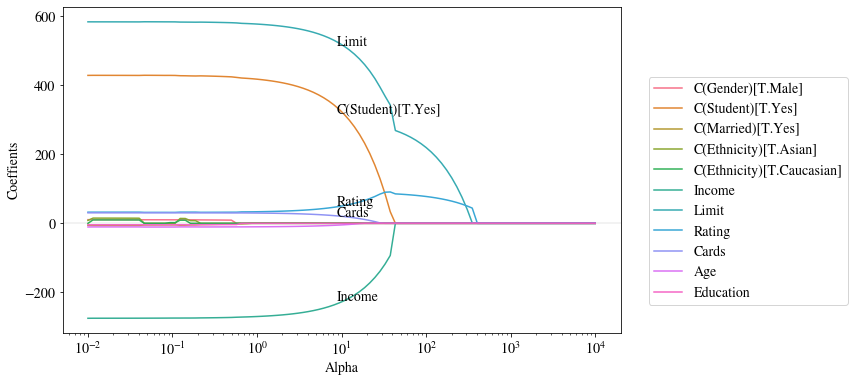

In [10]:
'''
Lasso变量选择，某些自变量系数估计值压缩为零。
'''
X = data
scaler = StandardScaler()
X[['Income','Limit','Rating','Cards','Age','Education']]=scaler.fit_transform(
    X[['Income','Limit','Rating','Cards','Age','Education']])
X['Balance']=data['Balance']

###模型包含了所有自变量，对于因子变量通过patsy的C函数转换成category类别变量
formula = 'Balance~Income+Limit+Rating+Cards+Age+Education+C(Gender)\
               +C(Student)+C(Married)+C(Ethnicity)'
model=smf.ols(formula,data=X)
result_ols=model.fit()
alpha=10**np.linspace(-2,4,100)
###系数的绝对值之和
betaols_l1=np.sum(np.abs(result_ols.params))
params_l1 = {}

params2_l1 = {}
for a in alpha:
    result = model.fit_regularized(L1_wt=1,alpha=a)
    params=result.params
    params_l1[a]=params
    rate=np.sum(np.abs(params))/betaols_l1
    ###保存每个alpha参数回归之后的系数与未正则化模型的系数
    #的l1范数之比作为字典的键，以系数作作为值
    #用于下个代码单元绘制正则化路径图。
    params2_l1[rate] = params
    
###lambda参数与对应的系数估计值，去掉截距项
params_l1 = pd.DataFrame(params_l1).T
params2_l1 = pd.DataFrame(params2_l1).T
del params_l1['Intercept']
del params2_l1['Intercept']
plt.figure(figsize = (10,6))
sns.lineplot(data = params_l1,dashes=False)
plt.axhline(y = 0,lw = 0.1,color = 'black')
plt.xticks(alpha,fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.ylabel('Coeffients',size=14)
plt.xlabel('Alpha',size=14)
plt.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=2,fontsize=14)

###在曲线上标注系数名(只标注值大于10的系数)
pnames=params_l1.iloc[50].iloc[np.where(np.abs(params_l1.iloc[50])>10)]
xn=pnames.name
for p in pnames.index:
    yn=pnames.loc[p]
    plt.text(xn-2,yn,p,fontsize=14)
plt.show()

In [11]:
pnames.index,pnames.name,pnames

(Index(['C(Student)[T.Yes]', 'Income', 'Limit', 'Rating', 'Cards'], dtype='object'),
 10.722672220103231,
 C(Student)[T.Yes]    315.840489
 Income              -224.199504
 Limit                513.030478
 Rating                51.418883
 Cards                 19.552916
 Name: 10.722672220103231, dtype: float64)

In [12]:
params_l1

,C(Gender)[T.Male],C(Student)[T.Yes],C(Married)[T.Yes],C(Ethnicity)[T.Asian],C(Ethnicity)[T.Caucasian],Income,Limit,Rating,Cards,Age,Education
0.010000,10.563768,428.526534,-5.653529,8.435623,0.000000,-275.084080,583.675173,32.274219,30.404194,-10.544515,-4.268603
0.011498,10.605433,428.690293,-6.280641,15.093877,9.870837,-274.944679,583.625610,32.322465,30.412895,-10.411943,-4.151370
0.013219,10.600946,428.673285,-6.268550,15.078504,9.859365,-274.936638,583.615496,32.323988,30.411364,-10.410843,-4.149627
0.015199,10.595786,428.653730,-6.254647,15.060829,9.846176,-274.927392,583.603867,32.325740,30.409604,-10.409578,-4.147623
0.017475,10.589855,428.631247,-6.238663,15.040507,9.831011,-274.916762,583.590496,32.327755,30.407580,-10.408124,-4.145319
...,...,...,...,...,...,...,...,...,...,...,...
5722.367659,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6579.332247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7564.633276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8697.490026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


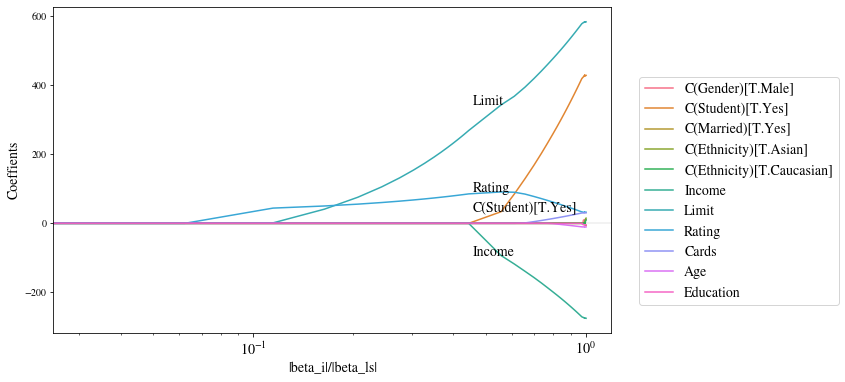

In [13]:
'''
下图可以看出变量进入模型的先后顺序-即所谓“正则化路径（regularization path）”
先后进入模型的变量依次是：Rating,Limit、Student和Income
'''
plt.figure(figsize = (10,6))
sns.lineplot(data = params2_l1,dashes=False)
plt.axhline(y = 0,lw = 0.1,color = 'black')
plt.xticks(alpha)
plt.xscale('log')
plt.ylabel('Coeffients',fontsize=14)
plt.xlabel('|beta_i|/|beta_ls|',fontsize=14)
plt.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=2,fontsize=14)

###在曲线上标注系数名(注：此处只标注值绝对值大于5的系数)，在第59个数据处进行标注
pnames=params2_l1.iloc[59].iloc[np.where(np.abs(params2_l1.iloc[59])>5)]
xn=pnames.name##lambda的值
for p in pnames.index:
    yn=pnames.loc[p]
    plt.text(xn-0.1,yn,p,fontsize=14)
plt.xticks(size=14)
plt.show()

- #### 正则化与变量选择

In [14]:
### 岭回归的模型正则化
#alpha=1000时，系数被缩减到0附近
result_test1 = model.fit_regularized(L1_wt=0,alpha=1000)
result_l2=result_test1.params
result_l2

array([ 0.51901361,  0.24543935,  0.08758112,  0.31653363,  0.13040066,
        0.25740861,  0.21206243,  0.39471856,  0.39560115,  0.03963808,
        0.00073846, -0.00367584])

In [15]:
### Lasso的变量选择
#设置alpha=4，很多系数被缩减为0
result_test = model.fit_regularized(L1_wt=1,alpha=20)
result_l1=result_test.params
result_l1

Intercept                    478.148450
C(Gender)[T.Male]              0.000000
C(Student)[T.Yes]            218.643566
C(Married)[T.Yes]              0.000000
C(Ethnicity)[T.Asian]          0.000000
C(Ethnicity)[T.Caucasian]      0.000000
Income                      -180.170159
Limit                        451.360756
Rating                        68.799025
Cards                          9.842547
Age                            0.000000
Education                      0.000000
dtype: float64

- #### 最优$\lambda$参数选择
选择fit_regularized函数参数$\alpha$的最优值

In [16]:
X1=data.copy()
dummies1 = pd.get_dummies(X1.Student, prefix='Student')
dummies2 = pd.get_dummies(X1.Gender, prefix='Gender')
dummies3 = pd.get_dummies(X1.Married, prefix='Married')
dummies4 = pd.get_dummies(X1.Ethnicity, prefix='Ethnicity')
X1=X1.drop('Student',axis=1).join(dummies1)
X1=X1.drop('Gender',axis=1).join(dummies2)
X1=X1.drop('Married',axis=1).join(dummies3)
X1=X1.drop('Ethnicity',axis=1).join(dummies4)
X1=X1.drop('Student_No',axis=1)
X1=X1.drop('Gender_Female',axis=1)
X1=X1.drop('Married_No',axis=1)
X1=X1.drop('Ethnicity_African American',axis=1)
scaler = StandardScaler()
X1[['Income','Limit','Rating','Cards','Age','Education','Balance']]=scaler.fit_transform( \
    X1[['Income','Limit','Rating','Cards','Age','Education','Balance']])
#X1['Balance']=data['Balance']
dummies1,X1.head()

(     Student_No  Student_Yes
 1             1            0
 2             0            1
 3             1            0
 4             1            0
 5             1            0
 ..          ...          ...
 396           1            0
 397           1            0
 398           1            0
 399           1            0
 400           1            0
 
 [400 rows x 2 columns],
      Income     Limit    Rating     Cards       Age  Education   Balance  \
 1 -0.861583 -0.489999 -0.465539 -0.699130 -1.257674  -0.784930 -0.407277   
 2  1.727437  0.828261  0.828703  0.031032  1.528451   0.496588  0.834056   
 3  1.686756  1.014787  1.029311  0.761194  0.889964  -0.784930  0.130634   
 4  2.946152  2.068440  2.110003  0.031032 -1.141586  -0.784930  0.966900   
 5  0.302928  0.070012  0.013331 -0.699130  0.715831   0.816968 -0.411633   
 
    Student_Yes  Gender_Male  Married_Yes  Ethnicity_Asian  Ethnicity_Caucasian  
 1            0            1            1                0         

In [17]:
'''
岭回归最优lambda参数选择
'''
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import Ridge,RidgeCV,LassoLarsIC
from sklearn.metrics import mean_squared_error

#拆分为训练集和测试集
predictors=['Income','Limit','Rating','Cards','Age','Education',
            'Student_Yes','Gender_Male','Married_Yes',
            'Ethnicity_Asian','Ethnicity_Caucasian']
            
x_train,x_test,y_train,y_test=model_selection.train_test_split(X1[predictors],
                                                               X1.Balance,test_size=0.2,
                                                               random_state=1234)

#构造不同的lambda值
Lambdas=np.logspace(-10,10,200)
#设置交叉验证的参数，使用均方误差评估
ridge_cv=RidgeCV(alphas=Lambdas,normalize=True,scoring='neg_mean_squared_error',cv=10)
ridge_cv.fit(x_train,y_train)

#基于最佳lambda值建模
ridge=Ridge(alpha=ridge_cv.alpha_,normalize=True)
ridge.fit(x_train,y_train)
#打印回归系数
print(pd.Series(index=['Intercept']+x_train.columns.tolist(),
                data=[ridge.intercept_]+ridge.coef_.tolist()))

#模型评估
ridge_pred=ridge.predict(x_test)
#均方误差
MSE=mean_squared_error(y_test,ridge_pred)
print('MSE:',MSE,'\naplha:',ridge_cv.alpha_)


Intercept             -0.108993
Income                -0.585111
Limit                  1.088484
Rating                 0.238970
Cards                  0.058086
Age                   -0.022707
Education             -0.002364
Student_Yes            0.926261
Gender_Male            0.030776
Married_Yes           -0.036078
Ethnicity_Asian        0.026058
Ethnicity_Caucasian    0.032685
dtype: float64
MSE: 0.040116497819261986 
aplha: 0.0003409285069746815


In [18]:
'''
Lasso的Lambda最优值选择。
使用sklearn相关函数，比如LassoCV等。
'''
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import Lasso,LassoCV
from sklearn.metrics import mean_squared_error

predictors=['Income','Limit','Rating','Cards','Age','Education',
            'Student_Yes','Gender_Male','Married_Yes',
            'Ethnicity_Asian','Ethnicity_Caucasian']
x_train,x_test,y_train,y_test=model_selection.train_test_split(X1[predictors],
                                                               X1.Balance,test_size=0.2,
                                                               random_state=1234)
#构造不同的lambda值
Lambdas=np.logspace(-5,10,200)
#设置交叉验证的参数，使用均方误差评估
lasso_cv=LassoCV(alphas=Lambdas,normalize=False,cv=10,max_iter=10000)
lasso_cv.fit(x_train,y_train)

#基于最佳lambda值建模
lasso=Lasso(alpha=lasso_cv.alpha_,normalize=True,max_iter=10000)
lasso.fit(x_train,y_train)
#打印回归系数
print('系数列表：',pd.DataFrame(index=['Intercept']+x_train.columns.tolist(),columns=[''],
                data=[lasso.intercept_]+lasso.coef_.tolist()))

#模型评估
lasso_pred=lasso.predict(x_test)
#均方误差
MSE=mean_squared_error(y_test,lasso_pred)
print('\nMSE:',MSE,'\n\n最优lambda：',lasso_cv.alpha_)


系数列表：                              
Intercept           -0.072096
Income              -0.272319
Limit                0.601981
Rating               0.412965
Cards                0.000000
Age                 -0.000000
Education            0.000000
Student_Yes          0.704441
Gender_Male          0.000000
Married_Yes         -0.000000
Ethnicity_Asian      0.000000
Ethnicity_Caucasian  0.000000

MSE: 0.1009724472137844 

最优lambda： 0.0036543830709572546


In [19]:
'''
使用LassoLarsIC函数通过AIC选择alpha值。
'''
X2=X1[predictors]
Y2=X1.Balance
model_aic = LassoLarsIC(criterion='aic',normalize=False)
model_aic.fit(X2,Y2)
alpha_aic_ = model_aic.alpha_
coefs_values=np.append([model_aic.intercept_],model_aic.coef_)
coefs_names=np.append(['Intercept'],predictors)
coefs=pd.DataFrame(coefs_values,index=coefs_names,columns=[' '])
print('系数列表:',coefs)
print('\nAlpha值:',alpha_aic_)

系数列表:                              
Intercept           -0.085427
Income              -0.568149
Limit                0.881575
Rating               0.428355
Cards                0.045606
Age                 -0.019789
Education            0.000000
Student_Yes          0.854274
Gender_Male          0.000000
Married_Yes          0.000000
Ethnicity_Asian      0.000000
Ethnicity_Caucasian  0.000000

Alpha值: 0.0061990099614554995


.

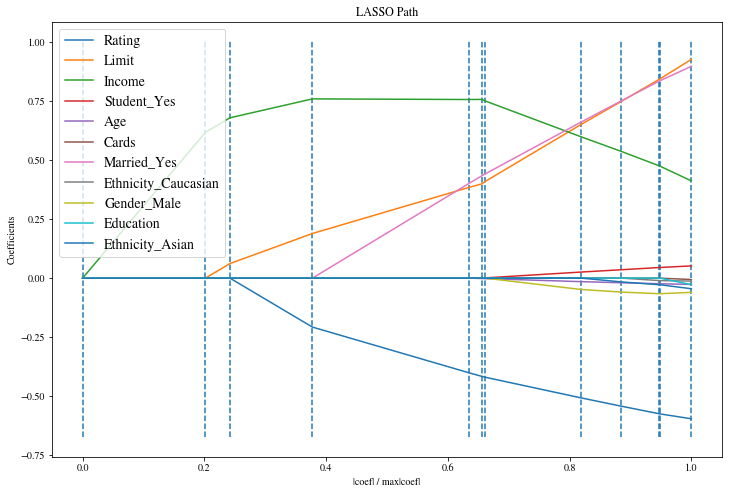

前四个进入模型的自变量： ['Rating' 'Limit' 'Income' 'Student_Yes']


In [20]:
'''
还可以使用sklearn的linear_model.lars_path()函数绘制正则化路径
'''

import matplotlib.pyplot as plt
from sklearn import linear_model
X3=np.array(X2)
Y3=np.array(Y2)
_, n3, coefs = linear_model.lars_path(X3, Y3, method='lasso',verbose=True)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]
plt.figure(figsize=[12,8])
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(np.array(predictors)[n3],fontsize=14)
plt.show()
print('前四个进入模型的自变量：',np.array(predictors)[n3[0:4]])

-----------------------------------

## 4.4 回归诊断<br>


### 4.4.1 三种残差
普通残差、标准化（内学生化）残差、外学生化残差

- #### 例1：分析气压和温度之间的关系<br>

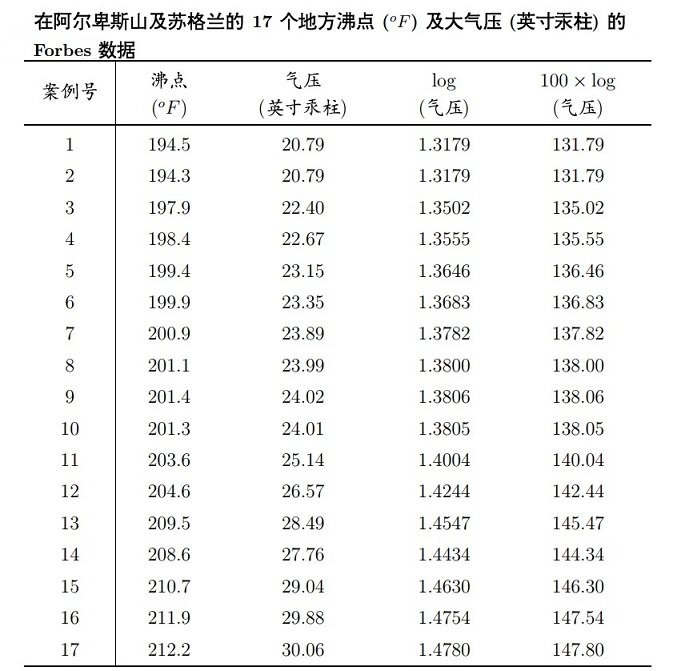

In [21]:
'''
使用沸点的温度（F）作为自变量，使用气压取对数乘以100（log100）作为因变量构建回归模型
'''
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
data = np.array([194.5, 20.79, 1.3179, 131.79,
                 194.3, 20.79, 1.3179, 131.79,
                 197.9, 22.40, 1.3502, 135.02,
                 198.4, 22.67, 1.3555, 135.55,
                 199.4, 23.15, 1.3646, 136.46,
                 199.9, 23.35, 1.3683, 136.83,
                 200.9, 23.89, 1.3782, 137.82,
                 201.1, 23.99, 1.3800, 138.00,
                 201.4, 24.02, 1.3806, 138.06,
                 201.3, 24.01, 1.3805, 138.05,
                 203.6, 25.14, 1.4004, 140.04,
                 204.6, 26.57, 1.4244, 142.44,
                 209.5, 28.49, 1.4547, 145.47,
                 208.6, 27.76, 1.4434, 144.34,
                 210.7, 29.04, 1.4630, 146.30,
                 211.9, 29.88, 1.4754, 147.54,
                 212.2, 30.06, 1.4780, 147.80])
###对数据进行预处理
data = np.reshape(data,(17,4))
data = pd.DataFrame(data,columns=("F", "h", "log", "log100"))
###formula公式
formula = 'y~X'
lm_ols = smf.ols(formula,data={'y':data.log100, 'X':data.F,})
results1_1 = lm_ols.fit()
results1_1.summary()

f:\users\hp\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2965.
Date:                Mon, 16 Aug 2021   Prob (F-statistic):           1.18e-18
Time:                        12:12:02   Log-Likelihood:                -6.5592
No. Observations:                  17   AIC:                             17.12
Df Residuals:                      15   BIC:                             18.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -42.1309      3.339    -12.618      0.000     -49.248     -35.014
X              0.8955      0.016     54.450      0.000       0.860       0.931
==============================================================================
Omnibus:                       38.307   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.790
Skew:                           3.183   Prob(JB):                     4.30e-21
Kurtosis:                      12.585   Cond. No.                     7.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

 #### 三种残差：

 
#####  (1)普通残差

#####  (2)标准化(内学生化)残差

#####  (3)外学生化残差




In [22]:
'''
三种残差的计算
'''
###帽子矩阵的计算
x = np.matrix(results1_1.model.wexog)##自变量设计矩阵
###pinv函数计算Moore-Penrose伪逆矩阵。在矩阵是奇异矩阵，即非满秩矩阵时，矩阵没有逆矩阵
#但是可以通过pinv计算其伪逆矩阵。
H = np.dot(np.dot(x,np.linalg.pinv(np.dot(x.T,x))),x.T)

res_model=results1_1.resid
print('模型结果resid变量的值：',np.array(res_model))
#单位矩阵I
im=np.identity(H.shape[0])
#获得因变量
y=results1_1.model.wendog#或data.log100，或data['log100']
###计算普通残差
res=np.dot(im-H,y)
print('\n通过公式计算的普通残差：',np.array(res))

模型结果resid变量的值： [-0.24659031 -0.0674978  -0.06116289  0.02110585  0.03564332 -0.04208794
  0.05244954  0.05335703 -0.15528173 -0.07573547 -0.14529928  1.35923819
  0.00147182 -0.3226119  -0.24308321 -0.07763824 -0.08627699]

通过公式计算的普通残差： [[-0.24659031 -0.0674978  -0.06116289  0.02110585  0.03564332 -0.04208794
   0.05244954  0.05335703 -0.15528173 -0.07573547 -0.14529928  1.35923819
   0.00147182 -0.3226119  -0.24308321 -0.07763824 -0.08627699]]


In [23]:
'''
标准化残差(内学生化残差)
'''
###帽子矩阵的对角线元素
hii=np.diag(H)
'''
###
帽子矩阵对角线的另一种计算方法。
'''

###手工计算标准化残差
#获得OLSInfluence对象
influ1_1=results1_1.get_influence()
#模型结果中的标准化残差
inf_isres=influ1_1.resid_studentized_internal
print('模型结果的标准化残差：',inf_isres)
#计算残差标准差的无偏估计,res_model为普通残差，df_resid为残差自由度
sigma=np.sqrt(np.sum(res_model**2)/results1_1.df_resid)
#计算标准化（内学生化）残差
isres=np.array(res_model/(sigma*(1-hii)**0.5))
print('\n手工计算的标准化残差：',isres)

模型结果的标准化残差： [-0.72468487 -0.19916136 -0.17081887  0.05864913  0.09821814 -0.11558547
  0.14329707  0.14566162 -0.42347433 -0.20660753 -0.39545899  3.70795021
  0.00418786 -0.90711019 -0.70502414 -0.23049112 -0.25782046]

手工计算的标准化残差： [-0.72468487 -0.19916136 -0.17081887  0.05864913  0.09821814 -0.11558547
  0.14329707  0.14566162 -0.42347433 -0.20660753 -0.39545899  3.70795021
  0.00418786 -0.90711019 -0.70502414 -0.23049112 -0.25782046]


In [24]:
'''
外学生化残差的计算，用looo方式计算外学生化残差
'''
###模型的外学生化残差
inf_esres=influ1_1.resid_studentized_external
print('模型结果的外学生化残差：',np.array(inf_esres))
###手工计算的外标准化残差（使用公式计算的结果和StatsModels一致）
#res_model为普通残差
esres=res_model*((results1_1.df_resid-1)/(np.sum(res_model**2)*(1-hii)-res_model**2))**0.5
print('\n手工计算的外学生化残差：',np.array(esres))

模型结果的外学生化残差： [-7.12699486e-01 -1.92663060e-01 -1.65187452e-01  5.66669375e-02
  9.49182692e-02 -1.11715932e-01  1.38532978e-01  1.40822128e-01
 -4.11582776e-01 -1.99886460e-01 -3.84056986e-01  1.24036925e+01
  4.04585534e-03 -9.01424962e-01 -6.92691672e-01 -2.23070953e-01
 -2.49631950e-01]

手工计算的外学生化残差： [-7.12699486e-01 -1.92663060e-01 -1.65187452e-01  5.66669375e-02
  9.49182692e-02 -1.11715932e-01  1.38532978e-01  1.40822128e-01
 -4.11582776e-01 -1.99886460e-01 -3.84056986e-01  1.24036925e+01
  4.04585534e-03 -9.01424962e-01 -6.92691672e-01 -2.23070953e-01
 -2.49631950e-01]


### 4.4.2 残差图
对模型进行诊断的重要工具



#### (1) 以回归值$\hat{y}$作为横坐标的残差图

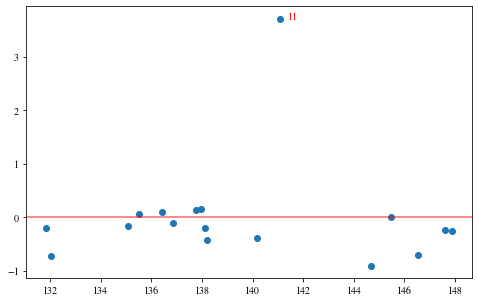

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
y_hat=results1_1.predict()#获取因变量的回归值

plt.figure(figsize=(8,5))
plt.scatter(y_hat,isres)#残差图

#画出参考线y=0
plt.axhline(y=0,alpha=0.6,color='red')
expt_index=np.argmax(np.abs(np.array(isres)))
ex=y_hat[expt_index]

#标出离群点
plt.text(ex+0.3,isres[expt_index],str(expt_index),c='r')
plt.show()

In [26]:
'''
去掉第11条（下标从0开始）数据后再进行拟合。
'''
data_F = data.F[np.arange(0,len(data.F))!=11]
data_log100 = data.log100[np.arange(0,len(data.log100))!=11]
results1_2 = smf.ols(formula,data={'X':data_F,'y':data_log100}).fit()
res_except11 = results1_2.resid
results1_2.summary()

f:\users\hp\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.266e+04
Date:                Mon, 16 Aug 2021   Prob (F-statistic):           5.55e-25
Time:                        12:12:02   Log-Likelihood:                 13.214
No. Observations:                  16   AIC:                            -22.43
Df Residuals:                      14   BIC:                            -20.88
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -41.3018      1.000    -41.286      0.000     -43.447     -39.156
X              0.8910      0.005    180.734      0.000       0.880       0.902
==============================================================================
Omnibus:                        1.645   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                1.316
Skew:                          -0.630   Prob(JB):                        0.518
Kurtosis:                       2.377   Cond. No.                     7.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
'''
残差正态性的夏皮罗检验
'''
###夏皮罗检验(shapiro)函数的原假设是：被检验样本数据符合正态分布
print('去掉第11个数据点之前的残差正态性检验：',st.shapiro(res_model))
print('去掉第11个数据点之后的残差正态性检验：',st.shapiro(res_except11))

去掉第11个数据点之前的残差正态性检验： ShapiroResult(statistic=0.546539306640625, pvalue=3.3020596674759872e-06)
去掉第11个数据点之后的残差正态性检验： ShapiroResult(statistic=0.9221550226211548, pvalue=0.18269383907318115)


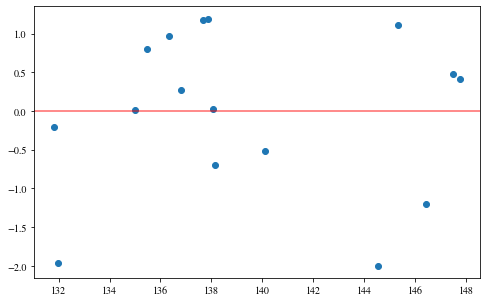

In [28]:
### 去除异常数据的标准化残差图
influ1_2=results1_2.get_influence()
y_hat2=results1_2.predict()#获取因变量的回归值
isres2=influ1_2.resid_studentized_internal
plt.figure(figsize=(8,5))
plt.scatter(y_hat2,isres2)#残差图
#画出参考线y=0
plt.axhline(y=0,alpha=0.6,color='red')
plt.show()

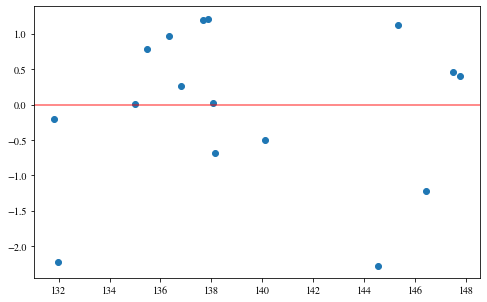

In [29]:
'''
使用外学生化残差图试试
'''

esres2=influ1_2.resid_studentized_external
plt.figure(figsize=(8,5))
plt.scatter(y_hat2,esres2)#残差图
#画出参考线y=0
plt.axhline(y=0,alpha=0.6,color='red')
plt.show()

#### (2) 残差QQ图
根据前面章节中介绍的QQ图原理，样本数据QQ图上的点如果大致分布在一条直线，那么该数据符合正态分布。

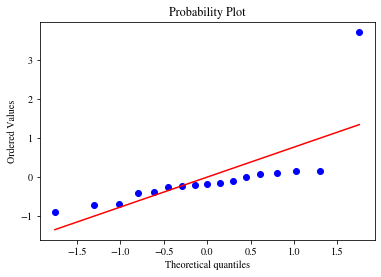

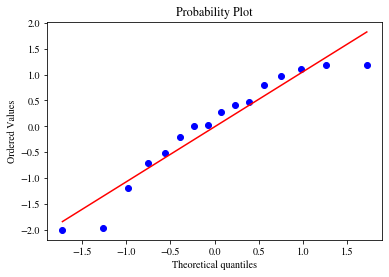

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


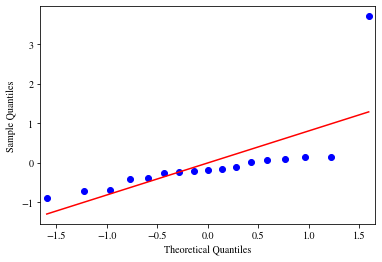

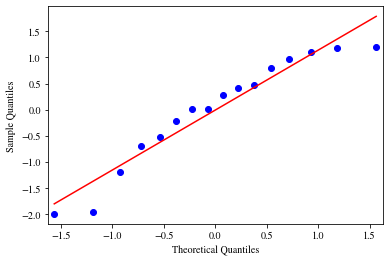

In [30]:
'''
残差QQ图
'''
### 去除离群点前的残差QQ图
st.probplot(isres,plot=plt)
plt.figure()

###去除离群点后的模型残差QQ图
st.probplot(isres2,plot=plt)
plt.show()

### 还可以使用StatsModels的qqplot函数绘制QQ图
#注意line参数的用法
import statsmodels.api as sm
sm.qqplot(isres,line='r')
sm.qqplot(isres2,line='r')
plt.show()

### 4.4.3 影响分析
探查对模型的回归估计有异常大影响的数据。样本中有一个数据不遵从某个模型，但是其他数据都遵从，则该样本点是强影响点。上节中通过残差可以探测离群点，下面介绍其他方法。主要关注两类异常数据：杠杆点和强影响点<br>


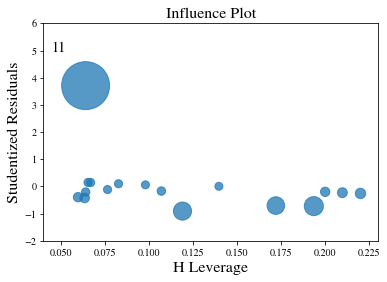

In [33]:
'''
Statsmodels的影响分析相关数据放在OLSInfluence对象里
通过模型的结果对象获取，详见前文。
'''
#影响分析
influ1_1.plot_influence()
plt.ylim(-2,6)
plt.xlim(0.04,0.23)
plt.show()

#### (1) DFFITS准则
模式预测值差异量


模型计算dffits值： [-3.49029139e-01 -9.62971659e-02 -5.71578858e-02  1.86654709e-02
  2.84824973e-02 -3.21268857e-02  3.70533931e-02  3.72188699e-02
 -1.07054336e-01 -5.22553169e-02 -9.66963947e-02  3.24164490e+00
  1.62954461e-03 -3.31142340e-01 -3.15595317e-01 -1.14885574e-01
 -1.32545561e-01] 
模型阈值： 0.6859943405700354

手工计算dffits：
 [-3.49029139e-01 -9.62971659e-02 -5.71578858e-02  1.86654709e-02
  2.84824973e-02 -3.21268857e-02  3.70533931e-02  3.72188699e-02
 -1.07054336e-01 -5.22553169e-02 -9.66963947e-02  3.24164490e+00
  1.62954461e-03 -3.31142340e-01 -3.15595317e-01 -1.14885574e-01
 -1.32545561e-01]
手工计算阈值： 0.6859943405700354

按照阈值，DFFITS统计量超过标准的数据点是 [11]


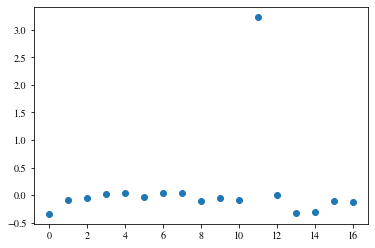

In [34]:
### 直接从OLSInfluence对象例取得该值。
dffits = influ1_1.dffits
print('模型计算dffits值：',dffits[0],'\n模型阈值：', dffits[1])

'''
使用公式手工计算
'''
dffits1 = esres* np.sqrt(hii / (1 - hii))
threshold_dffits=2*(2/17)**.5
print('\n手工计算dffits：\n',np.array(dffits1))
print('手工计算阈值：',threshold_dffits)
print('\n按照阈值，DFFITS统计量超过标准的数据点是',(np.where(np.abs(dffits[0]) > dffits[1]))[0])
plt.scatter(np.arange(len(dffits[0])),dffits[0])
plt.show()

#### (2) Cook统计量


模型库克距离：
 (array([6.29765505e-02, 4.95461931e-03, 1.74678678e-03, 1.86599953e-04,
       4.34320137e-04, 5.52437945e-04, 7.34504173e-04, 7.41045465e-04,
       6.06622216e-03, 1.45866825e-03, 4.95680839e-03, 4.69533612e-01,
       1.42254243e-06, 5.55213941e-02, 5.15892420e-02, 7.04568686e-03,
       9.36989623e-03]), array([0.93921241, 0.99505926, 0.99825494, 0.99981342, 0.99956579,
       0.99944773, 0.9992658 , 0.99925927, 0.99395458, 0.99854254,
       0.99505709, 0.6341802 , 0.99999858, 0.94618526, 0.94988665,
       0.99298236, 0.99067966]))

手工库克距离为：
 [6.29765505e-02 4.95461931e-03 1.74678678e-03 1.86599953e-04
 4.34320137e-04 5.52437945e-04 7.34504173e-04 7.41045465e-04
 6.06622216e-03 1.45866826e-03 4.95680839e-03 4.69533612e-01
 1.42254243e-06 5.55213942e-02 5.15892420e-02 7.04568686e-03
 9.36989623e-03]


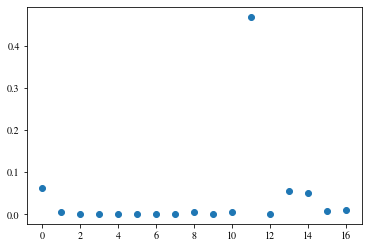

Cook距离统计量最高的数据点是: 11


In [35]:
'''
Cook距离。
'''
cook1 = influ1_1.cooks_distance
cook2 = (1/2)*(hii/(1-hii))*(isres**2)
print('模型库克距离：\n',cook1)
print('\n手工库克距离为：\n',cook2)
plt.scatter(range(len(cook2)),cook2)
plt.show()
##使用np.argmax函数
print('Cook距离统计量最高的数据点是:',np.argmax(cook2))

#### (3) COVRATIO准则


In [36]:
'''
COVRATIO准则
'''
cr = influ1_1.cov_ratio
### 根据COVRATIO准则，离1最远的那个值所对应的数据点为强影响点。
top_k_idx=np.argmax(np.abs(cr-1))
print('COVRATIO准则统计量最高的数据点是:',top_k_idx)

COVRATIO准则统计量最高的数据点是: 11


In [37]:
###根据外学生化残差推导公式和简化计算公式反推looo残差方差向量

sigma2_i=influ1_1.sigma2_not_obsi

###残差方差
sigma2=(np.sum(res_model**2)/results1_1.df_resid)
###根据COVRATIO准则公式计算COVRATIO值,和cr对比
np.array((sigma2_i**2/sigma2**2)*(1/(1-hii))),cr

(array([1.32536187, 1.42716636, 1.28040677, 1.27192597, 1.24971744,
        1.24068271, 1.2267188 , 1.22467554, 1.19649296, 1.21944392,
        1.19540813, 0.0085315 , 1.33418118, 1.16385341, 1.29589929,
        1.44217786, 1.4585813 ]),
 array([1.32536187, 1.42716636, 1.28040677, 1.27192597, 1.24971744,
        1.24068271, 1.2267188 , 1.22467554, 1.19649296, 1.21944392,
        1.19540813, 0.0085315 , 1.33418118, 1.16385341, 1.29589929,
        1.44217786, 1.4585813 ]))

#### (4) 其他影响衡量指标


In [38]:
'''
dfbetas：回归系数的标准化差分值或估计值差异量
'''
print('dfbetas：\n',np.array(influ1_1.dfbetas))
print('\n根据dfbetas值，强影响数据点为',np.where(influ1_1.dfbetas>2*np.sqrt(1/17))[0])

dfbetas：
 [[-0.29635088  0.29116408]
 [-0.08230325  0.08089618]
 [-0.03948936  0.03833712]
 [ 0.01218424 -0.01179046]
 [ 0.01593845 -0.01528276]
 [-0.01617394  0.01540386]
 [ 0.01373074 -0.01277838]
 [ 0.01268266 -0.01171484]
 [-0.031494    0.02866614]
 [-0.01619652  0.01482306]
 [ 0.00847536 -0.01112315]
 [-0.83061209  0.91653434]
 [-0.00120991  0.00123949]
 [ 0.22888737 -0.23538667]
 [ 0.25078446 -0.25596239]
 [ 0.09573156 -0.09744334]
 [ 0.1115131  -0.11344268]]

根据dfbetas值，强影响数据点为 [11]


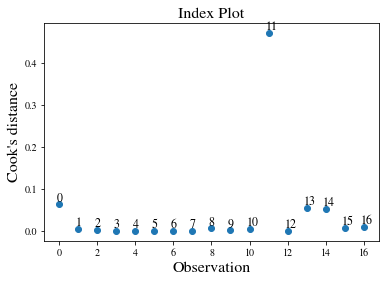

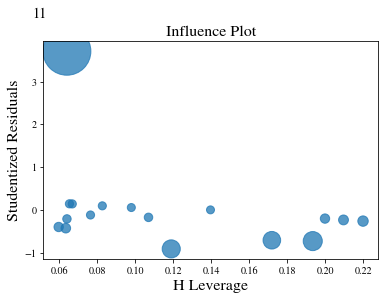

In [39]:
'''
可视化显示杠杆数据：leverage
'''
influ1_1.plot_index()
influ1_1.plot_influence()
plt.show()

In [40]:
'''
强影响诊断的统计量汇总：
(1) dfb_Intercept：dfbetas的截距项部分 
(2) dfb_X：dfbetas自变量回归系数部分的值
(3) cooks_d：库克距离
(4) standard_resid：标准化残差，或内学生化残差
(5) hat_diag：帽子矩阵对角线元素向量
(6) dffits_internal：使用内学生化残差计算的dffits
(7) student_resid：外学生化残差
(8) dffits：使用外学生化残差计算的dffits
'''
influ1_1.summary_frame()

,dfb_Intercept,dfb_X,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.296351,0.291164,0.062977,-0.724685,0.193440,-0.354899,-0.712699,-0.349029
1,-0.082303,0.080896,0.004955,-0.199161,0.199886,-0.099545,-0.192663,-0.096297
2,-0.039489,0.038337,0.001747,-0.170819,0.106927,-0.059106,-0.165187,-0.057158
3,0.012184,-0.011790,0.000187,0.058649,0.097878,0.019318,0.056667,0.018665
4,0.015938,-0.015283,0.000434,0.098218,0.082606,0.029473,0.094918,0.028482
5,-0.016174,0.015404,0.000552,-0.115585,0.076383,-0.033240,-0.111716,-0.032127
6,0.013731,-0.012778,0.000735,0.143297,0.066764,0.038328,0.138533,0.037053
7,0.012683,-0.011715,0.000741,0.145662,0.065292,0.038498,0.140822,0.037219
8,-0.031494,0.028666,0.006066,-0.423474,0.063367,-0.110147,-0.411583,-0.107054
9,-0.016197,0.014823,0.001459,-0.206608,0.063971,-0.054012,-0.199886,-0.052255


### 4.4.4 多重共线性
回归变量之间不存在线性关系，即称之为为正交的。如果回归变量存在线性关系，那么回归模型的推断就有可能出现问题。比如鉴定回归变量的相对影响，通过模型进行预测或估计等等。

- #### 例3：多重共线性的测量<br>
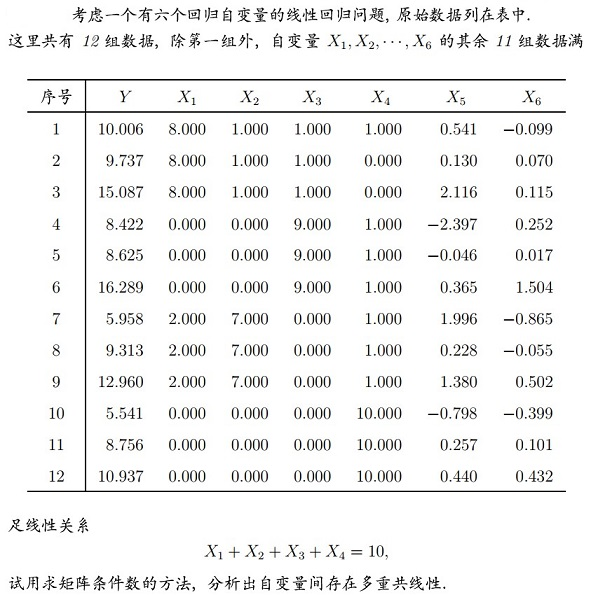

In [41]:
y=np.array([10.006, 9.737, 15.087, 8.422, 8.625, 16.289,
            5.958, 9.313, 12.960, 5.541, 8.756, 10.937])
x1=np.repeat([8, 0, 2, 0], [3, 3, 3, 3])
x2=np.repeat([1, 0, 7, 0], [3, 3, 3, 3])
x3=np.repeat([1, 9, 0], [3, 3, 6])
x4=np.repeat([1, 0, 1, 10], [1, 2, 6, 3])
x5=np.array([0.541, 0.130, 2.116, -2.397, -0.046, 0.365,
             1.996, 0.228, 1.38, -0.798, 0.257, 0.440])
x6=np.array([0.099, 0.070, 0.115, 0.252, 0.017, 1.504,
             -0.865, -0.055, 0.502, -0.399, 0.101, 0.432])
X = np.c_[x1,x2,x3,x4,x5,x6]
XY = np.c_[X,y]
formula='y~X'
result=smf.ols(formula,data={'y':y,'X':X}).fit()
result.summary()

f:\users\hp\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     14.52
Date:                Mon, 16 Aug 2021   Prob (F-statistic):            0.00499
Time:                        12:12:15   Log-Likelihood:                -13.236
No. Observations:                  12   AIC:                             40.47
Df Residuals:                       5   BIC:                             43.87
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.6531     14.033      1.899      0.116      -9.419      62.726
X[0]          -1.5306      1.339     -1.143      0.305      -4.974       1.913
X[1]          -1.8378      1.416     -1.298      0.251      -5.478       1.803
X[2]          -1.7747      1.414     -1.255      0.265      -5.409       1.859
X[3]          -1.8433      1.402     -1.315      0.246      -5.448       1.761
X[4]           1.0232      0.391      2.617      0.047       0.018       2.028
X[5]           5.0470      0.728      6.936      0.001       3.177       6.918
==============================================================================
Omnibus:                        1.691   Durbin-Watson:                   2.381
Prob(Omnibus):                  0.429   Jarque-Bera (JB):                0.150
Skew:                           0.038   Prob(JB):                        0.928
Kurtosis:                       3.542   Cond. No.                         234.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
'''
使用R语言的Kappa函数求的条件数，多重共线性用于测量多个自变量之间是否存在线性关系
'''
dataFrame = pd.DataFrame(X)
cor_X = dataFrame.corr()#自变量矩阵的相关系数矩阵
eigs = np.linalg.eigh(cor_X)[0]#特征值，使用eigh函数，特征值从小到大排列
eigv = np.linalg.eigh(cor_X)[1]#特征向量矩阵，特征值eigs[i]的相应特征向量是eigv[:,i]
cond = np.max(eigs)/np.min(eigs)#用最大特征值除以最小特征值
#特征值的另一种计算方法，结果一样，和Statsmodels不同，不对结果开平方。
#cond = np.linalg.norm(cor_X,ord=2)*np.linalg.norm(np.linalg.inv(cor_X),ord=2)
print('自变量矩阵的条件数为:',np.round(cond,4))
#缺省情况下第1个是最小特征值，相应特征向量也是矩阵的第1列。
print('\n最小特征值',eigs[0],'\n对应的特征向量是',eigv[:,0])
#betas=np.round(np.array(eigv[:,0]),7)

自变量矩阵的条件数为: 2180.7967

最小特征值 0.0011065466503663475 
对应的特征向量是 [-0.44701145 -0.41991274 -0.54347799 -0.57308725 -0.0072682   0.00197808]


In [43]:
'''
Statsmodels计算条件数：
(1) 获取自变量的设计矩阵，即在自变量矩阵里加入一个元素为1的常数列
(2) 求设计矩阵转置与其自身的点积，该点积是一个对称矩阵
(3) 求点积的特征值与特征向量
(4) 用最大特征值除以最小特征值，即通常意义上的条件数
(5) Statsmodels模型的条件数是该值的平方根
'''
wx=result.model.wexog
wxx=np.dot(wx.T,wx)
eig,eigv=np.linalg.eigh(wxx)
cond1=np.max(eig)/np.min(eig)
np.round(cond1**0.5,0),np.round(cond1,3)

(234.0, 54533.034)

In [44]:
'''
去掉共线性严重的x1,x2,x3,x4之后再进行模型拟合
'''
formula2 = 'y~I(x5**2)+x6'
result2 = smf.ols(formula2,data=dataFrame).fit()
result2.summary()

f:\users\hp\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     10.54
Date:                Mon, 16 Aug 2021   Prob (F-statistic):            0.00438
Time:                        12:12:17   Log-Likelihood:                -23.479
No. Observations:                  12   AIC:                             52.96
Df Residuals:                       9   BIC:                             54.41
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.9557      0.755     11.859      0.000       7.247      10.664
I(x5 ** 2)     0.2997      0.295      1.016      0.336      -0.368       0.967
x6             5.0292      1.096      4.590      0.001       2.551       7.508
==============================================================================
Omnibus:                        4.959   Durbin-Watson:                   2.604
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                1.732
Skew:                           0.457   Prob(JB):                        0.421
Kurtosis:                       4.621   Cond. No.                         5.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 ##### 结果解读：
(1) 无论是使用R语言Kappa函数相同的方法计算的条件数，还是使用StatsModels计算条件数的平方，其值远大于1000，因此使用全部自变量进行拟合的模型存在严重的多重共线性问题。

(2) 通过使用最小特征值对应的特征向量构建的方程，可以看出x1,x2,x3,x4四个存在共线性，因此有必要进行处理，比如可以只使用其中一个变量和x5,x6等剩下变量拟合模型，或者干脆全部去掉。

(3) 实验结果是全部去掉效果最好,因为加入其中任何一个，其系数的t检验都不显著。

(4) 使用全部自变量进行拟合的结果可以看出，回归参数皆不显著，模型拟合效果很差。

(5) 去掉x1,x2,x3,x4只使用x5,x6进行拟合，模型效果不错。虽然在对残差进行正态性检验的效果不是很好，但是这个问题可以通过增加样本数据解决，毕竟现存模型只有12条数据。

------------